In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt

In [2]:
# Verifica si hay una GPU disponible, si no, usa la CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class TTTBoard(object):
    """
    Tic-tac-toe board (initialized empty).

    Board positions mapping:
    0|1|2
    -+-+-
    3|4|5
    -+-+-
    6|7|8
    the board positions map to a list: [0, 1, 2, 3, 4, 5, 6, 7, 8]

    Crosses are mapped to 1, circles are mapped to -1 and empty position are mapped to 0. p1 always play crosses.
    .|X|O
    -+-+-
    .|X|.
    -+-+-
    .|O|.
    this board is mapped to [0, 1, -1, 0, 1, 0, 0, -1, 0]

    """
    def __init__(self):
        self.board = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    def get_board(self):
        return self.board

    def get_empty_pos(self):
        """Returns a list of indexes of the board's empty positions."""
        return [index for index, value in enumerate(self.get_board()) if value == 0]

    def set_move(self, player_order, move):
        """
        Apply player's move to the board.

        Parameters
        ------
        player_order: int
            1 for p1, -1 for p2.
        move: int
            Integer from 0-8 (inclusive) indicating player's move on the board.
        """
        self.board[move] = player_order

    def is_over(self):
        """
        Verifies if the game is over.

        Returns
        -------
        result: boolean
            True if the game is over, False otherwise.
        winner: int
            1 for p1, -1 for p2, 0 for tie and -1 is the game is not over.
        """
        board = self.get_board()
        result, winner = False, -1
        if board[0] != 0 and len(set(board[:3])) == 1:
            result, winner = True, board[0]
        elif board[3] != 0 and len(set(board[3:6])) == 1:
            result, winner = True, board[3]
        elif board[6] != 0 and len(set(board[6:])) == 1:
            result, winner = True, board[6]
        elif board[0] != 0 and len(set([board[i] for i in (0, 3, 6)])) == 1:
            result, winner = True, board[0]
        elif board[1] != 0 and len(set([board[i] for i in (1, 4, 7)])) == 1:
            result, winner = True, board[1]
        elif board[2] != 0 and len(set([board[i] for i in (2, 5, 8)])) == 1:
            result, winner = True, board[2]
        elif board[0] != 0 and len(set([board[i] for i in (0, 4, 8)])) == 1:
            result, winner = True, board[0]
        elif board[2] != 0 and len(set([board[i] for i in (2, 4, 6)])) == 1:
            result, winner = True, board[2]
        elif not self.get_empty_pos():
            result, winner = True, 0
        return result, winner

    def __str__(self):
        board = self.get_board()
        board = ["X" if x == 1 else x for x in board]
        board = ["O" if x == -1 else x for x in board]
        board = ["." if x == 0 else x for x in board]
        return "{b[0]} | {b[1]} | {b[2]}\n--+---+---\n{b[3]} | {b[4]} | {b[5]}\n--+---+---\n{b[6]} | {b[7]} | {b[8]}\n\n".format(b=board)


In [4]:
test_board = TTTBoard()
test_board.set_move(1, 3)
print(test_board)
test_board.set_move(-1, 2)
print(test_board)

. | . | .
--+---+---
X | . | .
--+---+---
. | . | .


. | . | O
--+---+---
X | . | .
--+---+---
. | . | .




# Environment

In [13]:
class TicTacToeEnv:
    def __init__(self):
        self.board = TTTBoard()
        self.done = False
        self.current_player = 1  # 1 for Agent (Cross), -1 for Player (Circle)

    def reset(self):
        self.board = TTTBoard()
        self.done = False
        self.current_player = 1
        return self.get_state()
    
    def get_state(self):
        return np.array(self.board.get_board())
    
    def get_random_empty_action(self):
        return random.choice(self.board.get_empty_pos())

    def step(self, action):
        """Performs the given action and returns the new state, reward, and whether the game is done."""
        if self.done:
            raise Exception("Game is already over")
        
        empty_positions = self.board.get_empty_pos()
    
        # Verificar si la acción es inválida
        if action not in empty_positions:
            # Penalizar al agente por seleccionar una acción inválida
            reward = -2  # Penalización negativa
            done = False  # No terminamos el juego todavía
            next_state = np.array(self.board.get_board())
            return next_state, reward, done

        # Si la acción es válida, se realiza el movimiento
        self.board.set_move(self.current_player, action)

        # Continuar con el resto del código
        self.done, winner = self.board.is_over()
        
        # Define the reward system
        if self.done:
            if winner == 1:
                # agent won
                reward = 1
            elif winner == -1:
                # human won
                reward = -1
            else:  # Tie
                reward = 0.5
        else:
            reward = 0  # No reward until the game ends
        
        # Switch players
        self.current_player *= -1
        
        return np.array(self.board.get_board()), reward, self.done

    def render(self):
        print(self.board)


In [14]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        
        # Actor (Policy network)
        self.actor = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Linear(64, 9),
            nn.Softmax(dim=-1)
        )
        
        # Critic (Value network), we may merge actions and state...
        self.critic = nn.Sequential(
            nn.Linear(9, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        # Actor network output: probabilities for each action
        policy_dist = self.actor(x)
        
        # Critic network output: state-value estimation
        value = self.critic(x)
        
        return policy_dist, value

In [51]:
class PPOAgent:
    def __init__(self, env: TicTacToeEnv, device, epsilon=0.1, lr=1e-3, gamma=0.99, clip_param=0.2, epochs=10, batch_size=32):
        self.env = env
        self.gamma = gamma
        self.clip_param = clip_param
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device
        self.epsilon = epsilon

        self.model = ActorCritic().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state, epsilon=None):

        if epsilon is None:
            epsilon = self.epsilon
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        empty_positions = self.env.board.get_empty_pos()

        # Si solo hay una posición vacía, selecciona esa directamente
        if len(empty_positions) == 1:
            action = empty_positions[0]

        else:
            # Obtener la distribución de probabilidades para todas las acciones (0-8)
            policy_dist, _ = self.model(state)

            # Crear una máscara basada en las posiciones vacías
            mask = torch.zeros_like(policy_dist)
            mask[0, empty_positions] = 1  # Asignar 1 a las posiciones vacías

            # Aplicar la máscara a la distribución de probabilidades
            masked_policy_dist = policy_dist * mask

            # Normalizar las probabilidades para que sumen 1 después de aplicar la máscara
            masked_policy_dist = masked_policy_dist / masked_policy_dist.sum()

            # Usar epsilon-greedy para explorar o explotar
            dice = random.random()
            if dice < epsilon:
                with torch.no_grad():
                    # Explotar: seleccionar la acción con mayor probabilidad (greedy)
                    action = torch.argmax(masked_policy_dist).item()
            else:
                # Explorar: usar la distribución categórica con la máscara aplicada
                dist = torch.distributions.Categorical(masked_policy_dist)
                action = dist.sample().item()

        return action


    def compute_advantages(self, rewards, values, next_value, dones):
        # advantages ayudan a determinar qué tan buena fue una acción en comparación con el valor promedio esperado en un determinado estado.
        # Advantage=(reward recibido+γ×valor futuro estimado)−valor actual estimado

        advantages = []
        gae = 0
        for step in reversed(range(len(rewards))):
            # Starts from the final step of the episode, we use the final state value
            # Si next_value o values provienen de la salida de un critic (parte de la arquitectura actor-critic), estos valores probablemente sean el resultado de una red neuronal. En ese caso, PyTorch automáticamente rastrea el cálculo porque esos valores son resultado de operaciones que involucran parámetros entrenables.
            delta = rewards[step] + self.gamma * next_value * (1 - dones[step]) - values[step]

            # Generalized Advantage Estimation (GAE), una técnica que mejora la estabilidad de las ventajas usando un promedio ponderado.
            gae = delta + self.gamma * 0.95 * gae
            advantages.insert(0, gae)
            next_value = values[step]
        return advantages

    def update(self, states, actions, rewards, dones, values, next_value):

        total_loss = 0  # Acumula la pérdida total

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        values = torch.FloatTensor(values).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        next_value = torch.FloatTensor([next_value]).to(self.device)

        advantages = self.compute_advantages(rewards, values, next_value, dones)
        advantages = torch.FloatTensor(advantages).to(self.device)
        # returns es la suma de las ventajas más los valores estimados de los estados. En Reinforcement Learning, el return se refiere a la suma de las recompensas esperadas futuras para un estado dado.

        returns = advantages + values  # Verificar mapeo correcto

        for epoch in range(self.epochs):

            for start in range(0, len(states), self.batch_size):
                end = start + self.batch_size

                # Slicing array and converting to tensor probably put all on cpu
                batch_states = states[start:end].to(self.device)
                batch_actions = actions[start:end].to(self.device)
                batch_returns = returns[start:end].to(self.device)
                batch_advantages = advantages[start:end].to(self.device)

                # Compute new policy (on batch over states nx9 is the shape of policy_dist, and nx1 for values)
                policy_dist, value = self.model(batch_states)
                dist = torch.distributions.Categorical(policy_dist)
                # For every array, search de action taken in that prob array and take the log
                log_probs = dist.log_prob(batch_actions)
                # Desconecta log_probs del grafo computacional para evitar que los gradientes se propaguen hacia atrás en estas probabilidades, ya que las usaremos para comparar con la política nueva (necesitamos esta comparación para la optimización PPO). En otras palabras, old_log_probs es la política anterior antes de la actualización del modelo.
                old_log_probs = log_probs.detach()

                # Compute value loss. Se elimina la segunda dimensión si tiene valor de 1
                value_loss = self.loss_fn(value.squeeze(1), batch_returns)

                # Compute policy loss

                # Calcula el ratio de probabilidad entre la política nueva (log_probs) y la antigua (old_log_probs). Este ratio nos indica si el nuevo modelo está tomando decisiones muy diferentes de las que tomaba antes.
                ratio = torch.exp(log_probs - old_log_probs)

                # Calcula la ventaja ponderada por el ratio de las probabilidades. Si el ratio es cercano a 1, significa que la nueva política es muy parecida a la anterior. Si el ratio es mayor o menor a 1, el valor del ratio pondera las ventajas.
                surrogate1 = ratio * batch_advantages

                # Para evitar actualizaciones demasiado grandes (que podrían desestabilizar el entrenamiento), el ratio se limita entre 1 - clip_param y 1 + clip_param (esto es conocido como clipping). Esto asegura que la nueva política no cambie demasiado respecto a la antigua.
                surrogate2 = torch.clamp(ratio, 1 - self.clip_param, 1 + self.clip_param) * batch_advantages
                
                # PPO minimiza la función de pérdida eligiendo entre las dos funciones surrogate (la normal y la clippeada). Se toma la mínima porque queremos penalizar las actualizaciones que hagan que la política cambie demasiado.
                policy_loss = -torch.min(surrogate1, surrogate2).mean()

                # Total loss
                # La pérdida total es la suma de la pérdida de valor (del critic) y la pérdida de política (del actor). Ambos componentes deben optimizarse para mejorar tanto la estimación de valor de los estados como la política de selección de acciones.
                loss = value_loss + policy_loss
                total_loss += loss  # Sumar la pérdida a total_loss

                # Update model

                # Resetea los gradientes acumulados de las iteraciones anteriores para que no se acumulen gradientes de pasos previos.
                self.optimizer.zero_grad()

                # Realiza la propagación hacia atrás (backpropagation) para calcular los gradientes de la pérdida total con respecto a los parámetros del modelo.
                loss.backward()

                # Actualiza los pesos del modelo (actor y critic) en función de los gradientes calculados.
                self.optimizer.step()
        
        return total_loss / (self.epochs * len(states))  # Retornar la pérdida promedio por batch

    def train(self, episodes=1000, episode_step_print=None, epsilon=None):
        self.train_loss = []
        self.train_rewards = []

        if episode_step_print is None:
            episode_step_print = episodes // 10

        start_time = time.time()
        cummulated_reward = 0
        for episode in range(episodes):
            
            state = self.env.reset()
            done = False
            # saves the whole game history first
            states, actions, rewards, dones, values = [], [], [], [], []

            episode_reward = 0
            while not done:

                # AGENT PLAY
                action = self.select_action(state, epsilon)
                next_state, reward, done = self.env.step(action)

                if not done:
                    # Adversarial plays
                    action_adversarial = self.env.get_random_empty_action()
                    next_state, reward_in_adversarial, done = self.env.step(action_adversarial)
                    reward += reward_in_adversarial

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                dones.append(done)

                _, value = self.model(torch.FloatTensor(state).unsqueeze(0).to(self.device))
                values.append(value.item())

                episode_reward += reward

                state = next_state

            _, next_value = self.model(torch.FloatTensor(next_state).unsqueeze(0).to(self.device))
            
            # using game history is going to improve
            episode_mean_loss = self.update(states, actions, rewards, dones, values, next_value.item())
            
            self.train_loss.append(episode_mean_loss.item())

            cummulated_reward += episode_reward
            self.train_rewards.append(episode_reward)  # Guarda el reward acumulado para este episodio

            if (episode + 1) % episode_step_print == 0 or episode == 0 or episode == (episodes - 1):
                end_time = time.time()
                episode_duration = end_time - start_time
                print(f"Episode {episode + 1}/{episodes} episodes lapses completed in {episode_duration:.2f} seconds. Cummulated reward from last: {cummulated_reward:.4f}")
                start_time = end_time  # restart for the next lapse check
                cummulated_reward = 0

In [52]:
env = TicTacToeEnv()
agent = PPOAgent(env, device, epsilon=0.2)

In [53]:
agent.train(episodes=1000, epsilon=0.2)

Episode 1/1000 episodes lapses completed in 0.06 seconds. Cummulated reward from last: -1.0000
Episode 100/1000 episodes lapses completed in 4.43 seconds. Cummulated reward from last: 63.5000
Episode 200/1000 episodes lapses completed in 4.35 seconds. Cummulated reward from last: 84.0000
Episode 300/1000 episodes lapses completed in 4.39 seconds. Cummulated reward from last: 81.0000
Episode 400/1000 episodes lapses completed in 4.40 seconds. Cummulated reward from last: 83.5000
Episode 500/1000 episodes lapses completed in 4.36 seconds. Cummulated reward from last: 82.5000
Episode 600/1000 episodes lapses completed in 4.34 seconds. Cummulated reward from last: 90.0000
Episode 700/1000 episodes lapses completed in 4.26 seconds. Cummulated reward from last: 92.0000
Episode 800/1000 episodes lapses completed in 4.28 seconds. Cummulated reward from last: 97.0000
Episode 900/1000 episodes lapses completed in 4.37 seconds. Cummulated reward from last: 87.0000
Episode 1000/1000 episodes lapse

In [58]:
agent.train(episodes=1000, epsilon=1)

Episode 1/1000 episodes lapses completed in 0.07 seconds. Cummulated reward from last: 1.0000
Episode 100/1000 episodes lapses completed in 3.93 seconds. Cummulated reward from last: 92.5000
Episode 200/1000 episodes lapses completed in 3.94 seconds. Cummulated reward from last: 90.0000
Episode 300/1000 episodes lapses completed in 3.99 seconds. Cummulated reward from last: 89.0000
Episode 400/1000 episodes lapses completed in 4.03 seconds. Cummulated reward from last: 90.0000
Episode 500/1000 episodes lapses completed in 3.93 seconds. Cummulated reward from last: 91.0000
Episode 600/1000 episodes lapses completed in 3.86 seconds. Cummulated reward from last: 95.0000
Episode 700/1000 episodes lapses completed in 3.95 seconds. Cummulated reward from last: 94.0000
Episode 800/1000 episodes lapses completed in 3.97 seconds. Cummulated reward from last: 89.5000
Episode 900/1000 episodes lapses completed in 4.05 seconds. Cummulated reward from last: 94.0000


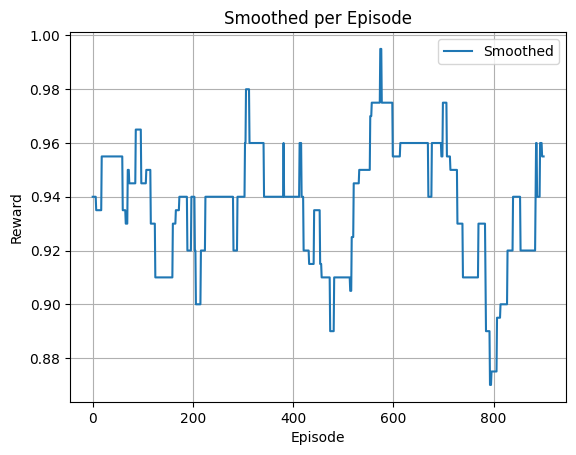

In [56]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed = moving_average(agent.train_rewards, window_size=min(100, len(agent.train_rewards) // 10))

# Asumiendo que tienes las pérdidas almacenadas en agent.train_loss
plt.plot(smoothed, label='Smoothed')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Smoothed per Episode')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
agent.epsilon = 1  # not training

env.reset()
env.step(2)
env.step(3)
env.step(1)
env.step(agent.select_action(env.get_state()))
env.step(agent.select_action(env.get_state()))
env.step(agent.select_action(env.get_state()))
env.render()

. | X | X
--+---+---
O | . | .
--+---+---
O | O | X




In [9]:
# Función para que el humano seleccione una posición
def get_human_move(env: TicTacToeEnv):
    empty_positions = env.board.get_empty_pos()
    move = None
    while move not in empty_positions:
        move = int(input(f"Seleccione su movimiento Valid: {[(i + 1) for i in empty_positions]}: ")) - 1
        if move not in empty_positions:
            print("Movimiento inválido, intente de nuevo.")
    return move


# Juego entre humano y agente
def play_human_vs_agent(agent, env):
    state = env.reset()
    env.render()

    while not env.done:
        if env.current_player == 1:
            # Turno del humano
            print("Turno del humano:")
            action = get_human_move(env)
        else:
            # Turno del agente
            print("Turno del agente:")
            action = agent.select_action(state)

        # Realiza el movimiento
        next_state, reward, done = env.step(action)
        env.render()
        state = next_state

    # Fin del juego
    if reward == 0.5:
        print("¡Empate!")
    elif reward > 0:
        print("¡El jugador", "humano" if env.current_player == -1 else "agente", "ha ganado!")
    else:
        print("¡El jugador", "humano" if env.current_player == 1 else "agente", "ha ganado!")

agent.epsilon = 1  # not training
play_human_vs_agent(agent, env)

. | . | .
--+---+---
. | . | .
--+---+---
. | . | .


Turno del humano:
X | . | .
--+---+---
. | . | .
--+---+---
. | . | .


Turno del agente:
X | . | .
--+---+---
O | . | .
--+---+---
. | . | .


Turno del humano:
X | X | .
--+---+---
O | . | .
--+---+---
. | . | .


Turno del agente:
X | X | .
--+---+---
O | . | .
--+---+---
. | O | .


Turno del humano:
X | X | X
--+---+---
O | . | .
--+---+---
. | O | .


¡El jugador humano ha ganado!


# END